# Предобработка текстов на русском языке. Извлечение ключевых слов и словосочетаний

## Предобработка текстов на русском языке
Для начала рассматриваем некоторое количество новостных сообщений, опубликованных в январе-феврале 2016 года, которые находятся в файле 'texts.json'. Мы считаем, что принципиальных различий между текстами нет, поэтому склеиваем их в один большой текст. 

In [1]:
%matplotlib inline
import json

infile = '../data/texts.json'


with open(infile) as data_file:    
    data = json.load(data_file)
collection = []
for i in data['data']:
    collection.append(i['text'])
print 'N of texts', len(collection)
merged_text = ' '.join(collection)

N of texts 221


In [3]:
import nltk
from nltk.tokenize import WhitespaceTokenizer
from string import punctuation
exclude = set(punctuation + '0123456789'+u'–—'+u'«»')
merged_text = ''.join(ch for ch in merged_text if ch not in exclude)
tokens = WhitespaceTokenizer().tokenize(merged_text.lower())
for i in tokens[:10]: print i 

как
вам
удалось
дать
настолько
точный
прогноз
у
меня
же


Используем самый простой токенизатор из NLTK, который разбивает тексты на токены по пробелам. Удаляем символы пунктуации, цифры и несколько разных видов тире. Приводим текст к нижнему регистру – на этом стандартная и минимальная обработка текста заканчивается.

In [27]:
print punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Токен – словоупотребление (слово + его место в тексте), тип – словоформа. Чтобы посчитать количество типов в тексте используем частотные словари NLTK.

In [28]:
print 'N of tokens: ', len(tokens)
types = nltk.FreqDist(tokens)
print 'N of types:', len(types)
print types

N of tokens:  148084
N of types: 27354
<FreqDist with 27354 samples and 148084 outcomes>


In [29]:
for i in types.most_common(20):
     print i[0], i[1]

в 6124
и 3733
на 3359
не 2036
что 1691
по 1686
с 1510
за 964
это 799
года 789
к 748
а 733
для 708
как 630
от 598
до 595
но 591
о 567
из 543
году 535


Построим кривую Ципфа для текста и убедимся, что она выглядит правильно.

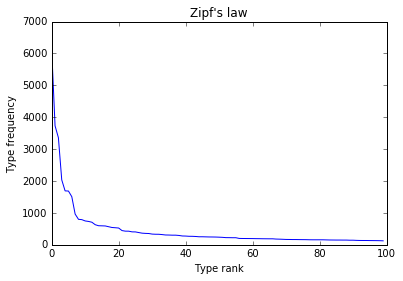

In [30]:
import matplotlib.pyplot as plt
fr = types.values()
fr.sort(reverse=True)
plt.plot(fr[:100])
plt.ylabel('Type frequency')
plt.xlabel('Type rank')
plt.title("Zipf's law")
plt.show()

Лемматизируем каждое слово с помощью PyMorphy2 и создаем частотный словарь лемм. 

In [31]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
lemmata = nltk.FreqDist()
for t in types:
    try:
        l = morph.parse(t)[0].normal_form
        if l in lemmata:
            lemmata[l] += types[t]
        else:
            lemmata[l] = types[t]
    except IndexError:
        if t in lemmata:
            lemmata[t] += types[t]
        else:
            lemmata[t] = types[t]
print 'N of lemmata:', len(lemmata)
for i in lemmata.most_common(20):
    print i[0], i[1]

N of lemmata: 13359
в 6243
и 3733
на 3359
не 2036
год 1771
что 1728
по 1686
с 1654
это 1391
быть 1368
за 964
рубль 951
который 796
к 756
а 733
о 730
тот 715
для 708
он 684
цена 641


Но разве все слова нам нужны? Не нужны нам стоп-слова: предлоги, местоимения, союзы и кое-что еще. 

In [32]:
from nltk.corpus import stopwords
for i in stopwords.words('russian'):
    print i,
mystopwords = stopwords.words('russian')+[u'это', u'иза', u'свой',u'млрд', u'млн',u'млна',u'тыс',u'трлн']

и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по только ее мне было вот от меня еще нет о из ему теперь когда даже ну вдруг ли если уже или ни быть был него до вас нибудь опять уж вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без будто чего раз тоже себе под будет ж тогда кто этот того потому этого какой совсем ним здесь этом один почти мой тем чтобы нее сейчас были куда зачем всех никогда можно при наконец два об другой хоть после над больше тот через эти нас про всего них какая много разве три эту моя впрочем хорошо свою этой перед иногда лучше чуть том нельзя такой им более всегда конечно всю между


Создаем список лемм без стоп-слов и снова обновляем частотный словарь.

In [33]:
lemmata_no_sw = nltk.FreqDist()
for l in lemmata:
    if not l in mystopwords:
        lemmata_no_sw[l] = lemmata[l]
for i in lemmata_no_sw.most_common(20):
    print i[0], i[1]

год 1771
рубль 951
который 796
цена 641
мочь 615
россия 563
весь 533
компания 466
рынок 454
нефть 453
страна 431
российский 429
доллар 404
экономика 337
миллиард 336
рост 333
говорить 308
банка 281
ещё 277
также 267


А теперь посмотрим только на существительные и подумаем о них как о *ключевых словах*.

In [34]:
nouns = nltk.FreqDist()
for t in types:
    if not t in mystopwords:
        try:
            gram_info = morph.parse(t)[0]
            if 'NOUN' in gram_info.tag:
                l = gram_info.normal_form
                if l in nouns:
                    nouns[l] += types[t]
                else:
                    nouns[l] = types[t]
        except IndexError:
            pass
print 'N of nouns:', len(nouns)
for i in nouns.most_common(20):
    print i[0], i[1]

N of nouns: 6331
год 1771
рубль 951
цена 641
россия 563
компания 466
рынок 454
нефть 453
страна 431
доллар 404
экономика 337
рост 333
банка 281
уровень 257
правительство 224
бюджет 223
слово 222
цб 222
курс 220
эксперт 215
время 212


## Извлечение ключевых словосочетаний по шаблону

Допустим, что ключевым может быть словосочетание, которое удовлетворяет хорошему грамматическому шаблону, например, СУЩ + СУЩ, ПРИЛ + СУЩ. Попробуем извлечь все такие пары слов из текста. Функция match() принимает на вход n-граму – последовательность из n слов и проверяет ее на соответствие каждому шаблону. 

In [35]:
from itertools import product
patterns = ['ADJF+NOUN','PRTS+NOUN','NOUN+NOUN']
    
def match(ngram, patterns = patterns):
    index = []
    for word in ngram:
        if word in mystopwords:
            return None
        buf = [(p.normal_form, p.tag.POS) for p in morph.parse(word)]
        index.append((word,buf)) 
    pos_tagging = product(*[ind[1] for ind in index])     
    possible_patterns = map(lambda pos_tag: zip(*pos_tag), pos_tagging) 
    possible_patterns = map(lambda pattern: [pattern[0], map(lambda grammeme: grammeme, pattern[1])], possible_patterns)
    possible_patterns = map(lambda pattern: (pattern[0], '+'.join(pattern[1])), possible_patterns)
    for pattern in possible_patterns:
       # print pattern
        if pattern[1] in patterns:
            return pattern

    return None
        

Применяем функцию к тексту. Сразу виден существенный недостаток этой функции – словосочетания несогласованы.

In [36]:
pattern_coll2  = nltk.FreqDist() 
count = 0
coll2 = nltk.FreqDist(nltk.bigrams(tokens))
for c2 in coll2:
    try:
        p = match(c2)
        if p != None:
            collocation = ' '.join(p[0])
            if collocation in pattern_coll2:
                pattern_coll2[collocation] += coll2[c2]
            else:
                pattern_coll2[collocation] = coll2[c2]
    except:
        pass

for c2 in pattern_coll2.most_common(10):
    print c2[0], c2[1]

прошлое год 143
курс рубль 67
декабрь год 65
саудовский аравия 61
январь год 53
рост цена 49
конец год 48
нефтяной цена 48
низкий цена 45
итог год 45


Совсем несогласованы.

In [37]:
m = match([u'точный', u'прогноз'])
print m[0][0], m[0][1], m[1]

m = match([u'веселая', u'музыка'])
print m[0][0], m[0][1], m[1]

точный прогноз ADJF+NOUN
весёлый музыка ADJF+NOUN


## Извлечение ключевых словосочетаний по статистическим мерам связности 

Используем реализацию из NLTK:
* генерируем список биграм
* удаляем биграмы, которые встречаются реже 3 раз
* находим 20 биграм с максимальным значением статистического критерия

Используем $t–score$.

In [38]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(3)
tscore_ranking = finder.nbest(bigram_measures.student_t, 20)
for i in tscore_ranking: print ' '.join(i)

в году
на нефть
при этом
в том
за баррель
в россии
цен на
том что
цены на
то есть
а также
долл за
том числе
по итогам
млрд рублей
в этом
за счет
кроме того
по данным
прошлого года


Удалим стоп-слова и повторим все шаги заново. 

In [39]:
finder.apply_word_filter(lambda w: w in mystopwords)
tscore_ranking = finder.nbest(bigram_measures.student_t, 40)
for i in tscore_ranking: print ' '.join(i)

прошлого года
прошлом году
первую очередь
января года
итогам года
таким образом
нефтяных цен
саудовской аравии
декабря года
декабре года
экономического роста
курс рубля
речь идет
черного золота
курса рубля
саудовская аравия
точки зрения
владимир путин
низких цен
ближайшее время
российской экономики
месяцев года
алексей улюкаев
нефтяных котировок
любом случае
рост цен
черное золото
сих пор
министр финансов
настоящее время
начале года
начала года
конце года
риа новости
дмитрий медведев
курс доллара
глава государства
роста цен
самом деле
аналитического управления


Используем  $PMI$.

In [40]:
pmi_ranking =  finder.nbest(bigram_measures.pmi, 40)
for i in pmi_ranking: print ' '.join(i)

liqui moly
shanghai composite
клаус шваб
нижний новгород
парниковых газов
температура кристаллизации
эксон нл
electric power
iron ore
new york
генеральная прокуратура
ксения юдаева
фридом финанс
взлетная полоса
ньюйоркская конвенция
хасан рухани
эммануэль ибе
fashion consulting
forex club
kyushu electric
merrill lynch
qb finance
анатолий аксаков
биологически активных
железную руду
кристин лагард
полезных ископаемых
южного потока
standard chartered
активных добавок
бытовой химии
временная администрация
естественных монополий
парламентских выборов
салем альбадри
ore mining
лук репчатый
dp world
jp morgan
mfx broker


Используем $\chi^2$.

In [18]:
chi2_ranking =  finder.nbest(bigram_measures.chi_sq, 20)
for i in chi2_ranking: print ' '.join(i).encode('utf8')

electric power
forex club
iron ore
liqui moly
mfx broker
new york
qb finance
shanghai composite
генеральная прокуратура
квадратного метра
клаус шваб
кристин лагард
ксения юдаева
нижний новгород
парниковых газов
температура кристаллизации
фридом финанс
эксон нл
черное золото
саудовская аравия


Используем $LogLikelihood Ratio$, $LLR$.

In [19]:
llr_ranking = finder.nbest(bigram_measures.likelihood_ratio, 20)
for i in llr_ranking: print ' '.join(i)

прошлого года
первую очередь
прошлом году
саудовской аравии
таким образом
черного золота
саудовская аравия
точки зрения
речь идет
нефтяных цен
черное золото
итогам года
сих пор
владимир путин
января года
экономического роста
риа новости
ближайшее время
алексей улюкаев
нефтяных котировок


Сравнение полученных ранжировок можно выполнить с помощью рангового коэффициента корреляции Спирмена.

Определение (http://www.machinelearning.ru/)

Заданы две выборки $x = (x_1,\ldots,x_n)$, $y = (y_1,\ldots,y_n)$.

Вычисление корреляции Спирмена:

Коэффициент корреляции Спирмена вычисляется по формуле:
$\rho=1-\frac{6}{n(n-1)(n+1)}\sum_{i=1}^n(R_i-S_i)^2$, где $R_i$ - ранг наблюдения $x_i$ в ряду $x$, $S_i$ - ранг наблюдения $y_i$ в ряду $y$.

In [20]:
from nltk.metrics.spearman import *
pmi_ranks =  ranks_from_sequence(pmi_ranking)
tscore_ranks = ranks_from_sequence(tscore_ranking)
print spearman_correlation(pmi_ranks, tscore_ranks)

0.0


In [21]:
llr_ranks =  ranks_from_sequence(llr_ranking)
tscore_ranks = ranks_from_sequence(tscore_ranking)
print spearman_correlation(llr_ranks, tscore_ranks)

0.133928571429


In [22]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens, window_size = 20)
finder.apply_freq_filter(2)

finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in mystopwords)

tscore_ranking = finder.nbest(bigram_measures.student_t, 20)

for i in tscore_ranking: print ' '.join(i)



долл баррель
прошлого года
нефть баррель
прошлом году
итогам года
рублей рублей
цен нефть
долл долл
руб руб
цены нефть
году году
курс рубля
первую очередь
января года
нефтяных цен
нефть долл
баррель долл
рубля рубля
таким образом
конце года


# Стемминг

In [23]:
from nltk.stem.snowball import RussianStemmer
stemmer = RussianStemmer()
print stemmer.stem(u'оптимизация')

оптимизац


Частотный словарь стемов (псевдооснов):

In [24]:
stems = nltk.FreqDist()
for t in types:
    if not t in mystopwords:
        stem = stemmer.stem(t)
        if stem in stems:
            stems[stem] += types[t]
        else:
            stems[stem] = types[t]
for i in stems.most_common(20):
    print i[0], i[1]

год 1619
котор 796
рубл 764
цен 651
росс 565
банк 481
компан 467
нефт 453
стран 440
российск 429
говор 405
так 359
экономик 339
рост 333
рынк 331
нов 299
такж 267
сам 263
дан 261
сво 248


# Задание 1

Найдите ключевые слова и словосочетания для произвольного текста с использованием грамматических шаблонов и хотя бы одной статистической меры связности. Прокомментируйте полученные результаты.

# Задание 2 

Напишите функцию concord(), которая принимает на вход:
* несогласованное словосочетание
* шаблон словосочетания
и возвращает согласованное словосочетание.

# Задание 3 

Реализуйте TextRank и сравните результаты его применения с результами задания 1.


# Литература

* Manning & Shuetze: Ch. 5 – Collocations

* NLTK Book: Collocations HOWTO http://www.nltk.org/howto/collocations.html

* Е. В. Ягунова, Л. М. Пивоварова,  "От конструкций к коллокациям" – http://webground.su/data/lit/pivovarova_yagunova/Ot_kollokatsiy_k_konstruktsiyam.pdf
